# Project 6

## Problem 1

Creating an algorithm which clusters based on the Manhattan(L1) distance metric using the Aggromerative Clustering method. 

#### Testing the algorithm on the toy data set. 
#### Implemented algorithm with the Manhattan distance has added a column to the row of images. 

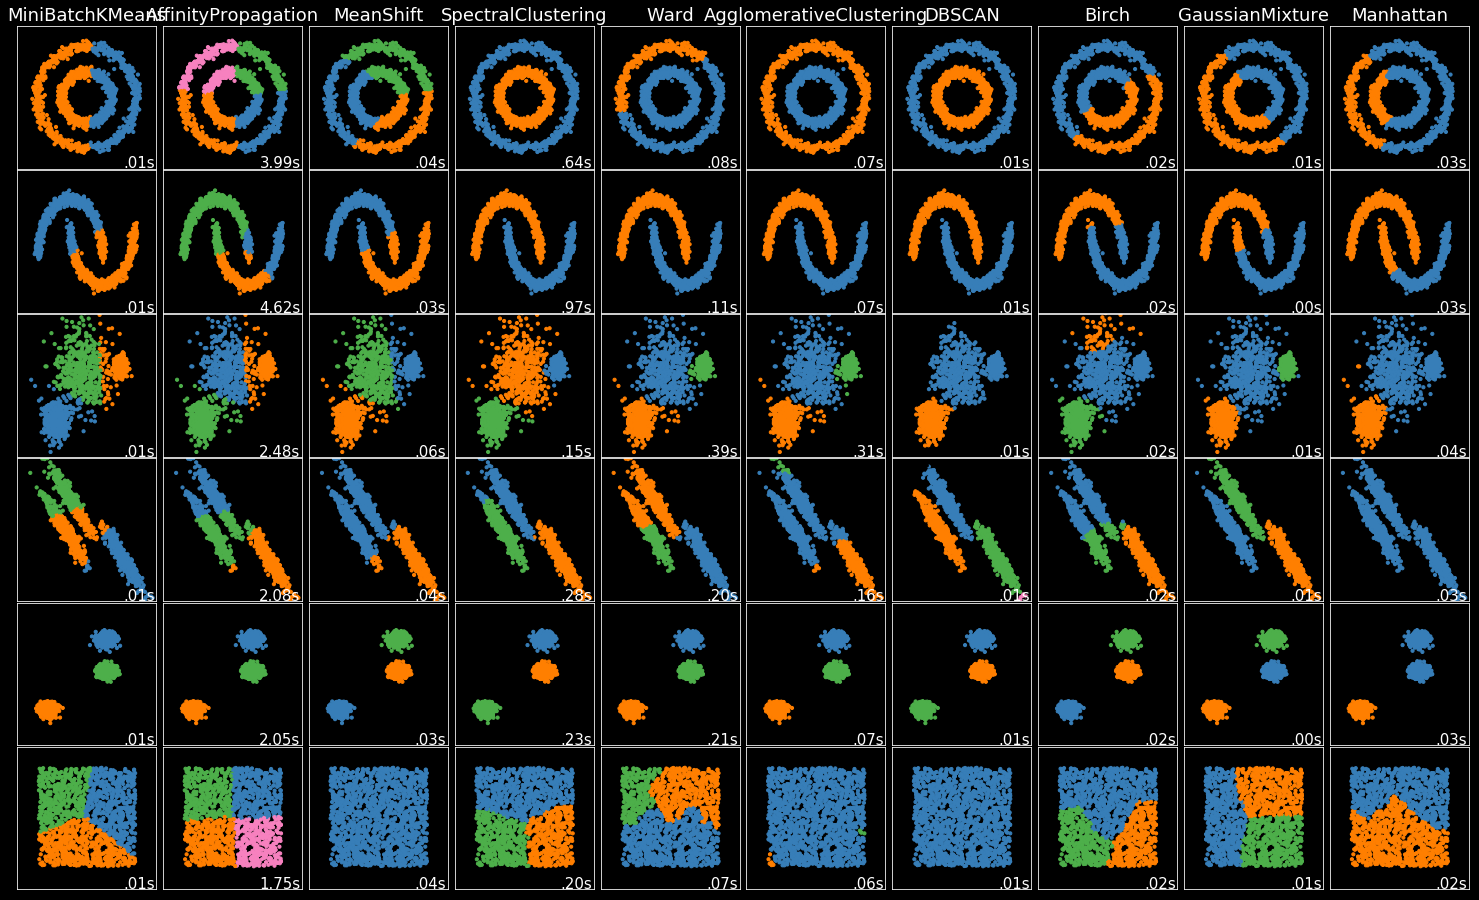

In [47]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    mandist = cluster.AgglomerativeClustering( affinity='manhattan', 
                                              linkage='average')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('Manhattan', mandist)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Interpretation:

From what we see from the Manhattan distace column, we observe that the clustering is very similar to the MiniBatch Kmeans in th first image. 

The second image in the Manhattan clustering is similar to the Mean shift. Although the cluster coloring has not shown many differences.

The third image shows that the clustering is fuzzy. As the blue colored images are soft and not distintly clustered. It is also similar to the DBSCAN clustering while the outliers are not seen distinctly in the Manhattan distance cluster. 

The fourth image does not show specific maps related to the color or cluster, which means that it is not clustering the hard way nor is it clustering the fuzzy way. All the clusters are clustered in the same category whilst the distance is still predominant. It does not match or is not similar to any of the other clusters in the other clustering algorithms. 

The fifth image also shows the clustering in the fuzzy pattern and not the hard pattern whilst the distance is between the clusters is still distinct. 

The last image shows that the clustering is the soft way and one or more parameters are over lapping in both the both the clusters. 

## Problem 2

### Auto Encoding:

Auto encoding reconstructs its input in a neural network. The auto encoding reduces the size of the images and applies an algorithm. It layers the representation of data. It helps for interpreting the data easily. It reduces the dimension of the data which makes it easier to the work with the data. 

For using under unsupervised learning, the data is reduced into a smaller dimension and this gives a better way of implementing the algorithm. 

The autoencoder initially compresses the original data into a smaller data and matches the data to original by uncompressing it after processing. 

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


1.10.1


In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
len(train_labels)


60000

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)


10000

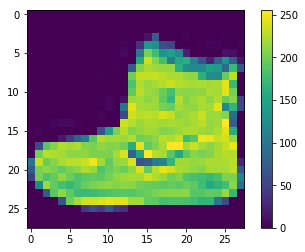

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)


In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0


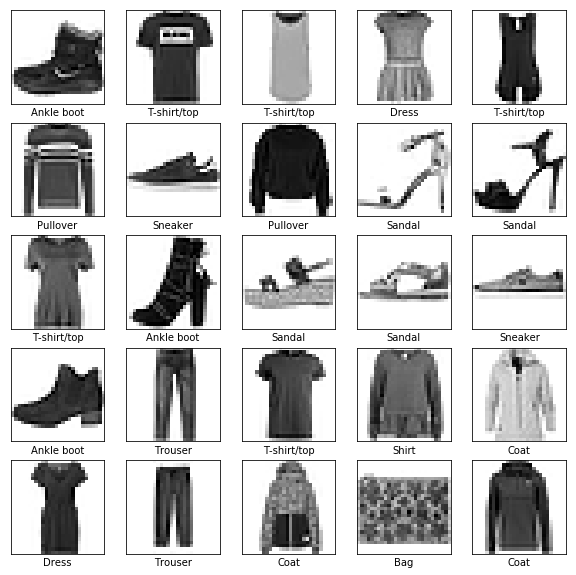

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])


In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])



In [14]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.4962 - acc: 0.8253
Epoch 2/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.3717 - acc: 0.8677
Epoch 3/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.3349 - acc: 0.8795
Epoch 4/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.3100 - acc: 0.8857
Epoch 5/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.2935 - acc: 0.8922


In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


10000/10000 [==============================] - 0s 16us/step
('Test accuracy:', 0.8754)


In [17]:
predictions = model.predict(test_images)


In [18]:
predictions[0]


array([4.22727226e-06, 1.04141286e-07, 5.56060684e-07, 5.06381816e-08,
       2.41815565e-06, 1.36038661e-03, 1.46989714e-05, 2.53569912e-02,
       3.04888854e-05, 9.73230124e-01], dtype=float32)

In [19]:
np.argmax(predictions[0])


9

In [20]:
test_labels[0]


9

In [21]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


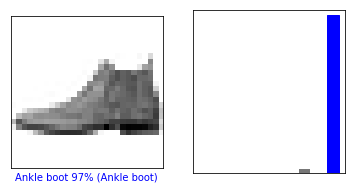

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


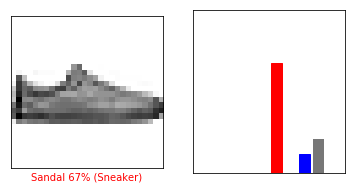

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


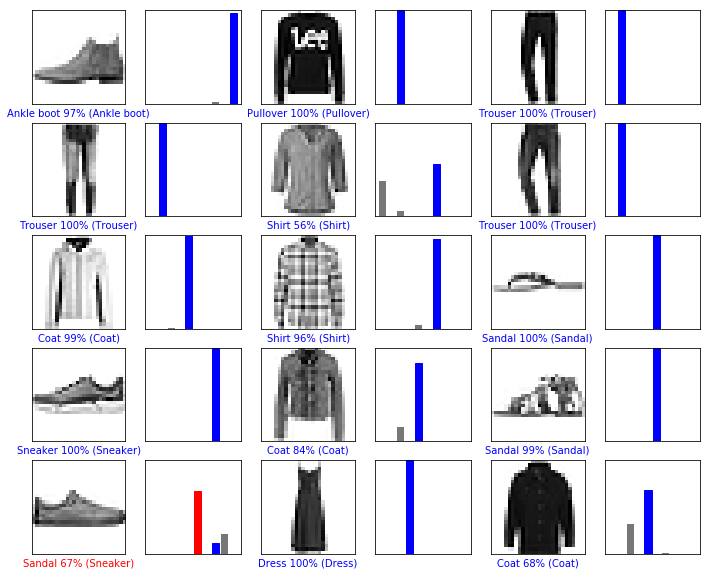

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)


(28, 28)


In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)


(1, 28, 28)


In [27]:
predictions_single = model.predict(img)

print(predictions_single)


[[4.2272641e-06 1.0414089e-07 5.5606176e-07 5.0638182e-08 2.4181513e-06
  1.3603832e-03 1.4698943e-05 2.5356956e-02 3.0488825e-05 9.7323012e-01]]


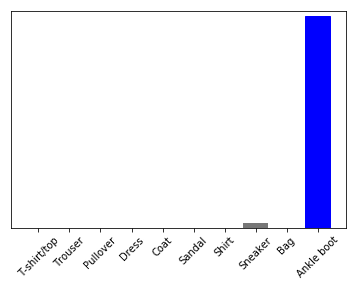

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)


In [29]:
np.argmax(predictions_single[0])


9

In [41]:
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_images)

In [ ]:
train_images = train_images[:5000]
train_labels = train_labels[:5000]
test_images = test_images[:5000]
test_labels = test_labels[:5000]

In [ ]:
for i in range(0,100):
    image_test = np.array(test_images[i],dtype='float')
    pixels_test=image_test.reshape(28, 28)
    plt.imshow(pixels_test,cmap='gray')
    plt.show() 

for i in range(0,100):
    image_train = np.array(train_images[i],dtype='float')
    pixels_train=image_train.reshape(28, 28)
    plt.imshow(pixels_train,cmap='gray')
    plt.show() 

In [50]:
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans

km= KMeans(n_clusters=10, init='random',n_init=10,max_iter=300, tol=1e-04,random_state=0)
y_km=km.fit_predict(train_images[:,1,:])


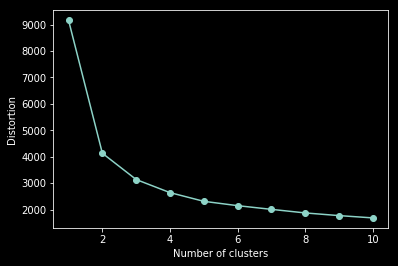

In [51]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=100, random_state=0)
    km.fit(train_images[:,1,:])
    distortions.append(km.inertia_)

   
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [44]:
plt.style.use('dark_background')

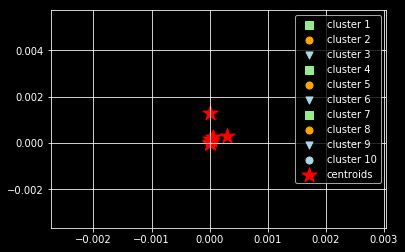

In [45]:
plt.scatter(train_images[:,1,:][y_km==0,0], train_images[:,1,:][y_km ==0,1], s=50, c='lightgreen', marker='s', label='cluster 1')
plt.scatter(train_images[:,1,:][y_km ==1,0],train_images[:,1,:][y_km ==1,1], s=50, c='orange', marker='o', label='cluster 2')
plt.scatter(train_images[:,1,:][y_km ==2,0], train_images[:,1,:][y_km ==2,1], s=50, c='lightblue', marker='v', label='cluster 3')
plt.scatter(train_images[:,1,:][y_km==3,0], train_images[:,1,:][y_km ==3,1], s=50, c='lightgreen', marker='s', label='cluster 4')
plt.scatter(train_images[:,1,:][y_km ==4,0],train_images[:,1,:][y_km ==4,1], s=50, c='orange', marker='o', label='cluster 5')
plt.scatter(train_images[:,1,:][y_km ==5,0], train_images[:,1,:][y_km ==5,1], s=50, c='lightblue', marker='v', label='cluster 6')
plt.scatter(train_images[:,1,:][y_km==6,0], train_images[:,1,:][y_km ==6,1], s=50, c='lightgreen', marker='s', label='cluster 7')
plt.scatter(train_images[:,1,:][y_km ==7,0],train_images[:,1,:][y_km ==7,1], s=50, c='orange', marker='o', label='cluster 8')
plt.scatter(train_images[:,1,:][y_km ==8,0], train_images[:,1,:][y_km ==8,1], s=50, c='lightblue', marker='v', label='cluster 9')
plt.scatter(train_images[:,1,:][y_km ==9,0], train_images[:,1,:][y_km ==9,1], s=50, c='lightblue', marker='o', label='cluster 10')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.show()
plt.figure.figsize= (15,8)

In [49]:
train_images.shape

(5000, 28, 28)

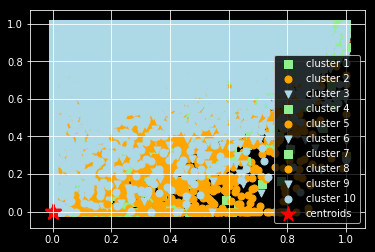

In [52]:
plt.scatter(train_images[y_km==0,0],train_images[y_km ==0,1], s=50, c='lightgreen', marker='s', label='cluster 1')
plt.scatter(train_images[y_km==1,0],train_images[y_km ==1,1], s=50, c='orange', marker='o', label='cluster 2')
plt.scatter(train_images[y_km==2,0],train_images[y_km ==2,1], s=50, c='lightblue', marker='v', label='cluster 3')
plt.scatter(train_images[y_km==3,0],train_images[y_km ==3,1], s=50, c='lightgreen', marker='s', label='cluster 4')
plt.scatter(train_images[y_km==4,0],train_images[y_km ==4,1], s=50, c='orange', marker='o', label='cluster 5')
plt.scatter(train_images[y_km==5,0],train_images[y_km ==5,1], s=50, c='lightblue', marker='v', label='cluster 6')
plt.scatter(train_images[y_km==6,0],train_images[y_km ==6,1], s=50, c='lightgreen', marker='s', label='cluster 7')
plt.scatter(train_images[y_km==7,0],train_images[y_km ==7,1], s=50, c='orange', marker='o', label='cluster 8')
plt.scatter(train_images[y_km==8,0],train_images[y_km ==8,1], s=50, c='lightblue', marker='v', label='cluster 9')
plt.scatter(train_images[y_km==9,0],train_images[y_km ==9,1], s=50, c='lightblue', marker='o', label='cluster 10')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.show()
plt.figure.figsize= (100,100)